## `statemodify` Quickstarter Notebook #1: Getting Started and Using the DDM and DDR Modification Functions in the San Juan River Basin

In this series of five notebooks, we demonstrate the functionality of `statemodify` using three of the five subbasins on the West Slope basin in the state of Colorado: Gunnison, San Juan/Dolores, and the Upper Colorado Basin. There are two classes of adjustments offered in `statemodify` that can be used to create alternative future states of the world for the region:  

1. Application of multipliers or additives to the original dataset which are sampled from specified bounds using a Latin hypercube sample  

2. Complete swap of input data with data generated from an external method

Option 1 is applicable to `.ddm` (monthly demand), `.ddr` (water rights), `.eva` (reservoir evaporation), `.res` (reservoir storage).

Option 2 is applicable to `.xbm` (monthly streamflow) and `.iwr` (irrigation demand). In `statemodify` we provide a Hidden Markov Model (HMM)-based approach to generate synthetic flows across the basins and tie in irrigation demand to be negatively correlated to increased streamflow. 

In this first notebook, we will demonstrate now to use the demand (`modify_ddm()`)and water rights (`modify_ddr()`) modification functions in the San Juan River Basin. Demands are projected to increase with the growth of cities and agriculture and water rights will likely change as discussions on changes to the Colorado Compact and re-allocation of water across the Colorado River Basin to promote sustainable development continue.   

<div class="alert alert-block alert-warning"> 
    
<b>Tip:</b> When each StateMod file is mentioned, clicking on the name will link the user to the <a href="https://opencdss.state.co.us/statemod/latest/doc-user/">StateMod documentation</a> with more information on that file.       

</div>

### Step 1: Run a Historical Simulation in StateMod for the San Juan Basin

Before we start on an exploratory modeling journey, you may be first interested in understanding water shortages that the basin has historically experienced. In the container, we have downloaded and compiled StateMod, `statemodify`, and the San Juan dataset from the Colorado's Decision Support System (CDSS) website. We can run a baseline simulation below which takes approximately 4 minutes. In this baseline simulation, we run StateMod over the length of the historical period (105 years) under the assumption that we are starting from current conditions. 

In [1]:
import argparse
import logging
import os
import pickle
from string import Template
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statemodify as stm

<div class="alert alert-block alert-info"> 
    
<b>NOTE</b>: Each simulation in this notebook is run for the length of the historical period (from 1909-2013). If you want to reduce the length of the simulation, navigate to the `.ctl` file and adjust the `iystr` and `iyend` variables. For this notebook, these files are located in: `data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod
Notebook/sj2015.ctl` and `data/gm2015_StateMod_modified/gm2015_StateMod_modified/StateMod/gm2015.ctl`  

</div>

In [2]:
# statemod directory
statemod_dir = "/usr/src/statemodify/statemod_gunnison_sjd"

# root directory of statemod data for the target basin
root_dir = os.path.join(statemod_dir, "src", "main", "fortran")

# home directory of notebook instance
home_dir = os.path.dirname(os.getcwd())

# path to the statemod executable
statemod_exe = os.path.join(root_dir, "statemod-17.0.3-gfortran-lin-64bit-o3")

# data directory and root name for the target basin
data_dir = os.path.join(
    home_dir,
    "data",
    "sj2015_StateMod_modified",
    "sj2015_StateMod_modified",
    "StateMod"
)

# directory to the target basin input files with root name for the basin
basin_path = os.path.join(data_dir, "sj2015B")

# scenarios output directory
scenarios_dir_ddm = os.path.join(data_dir, "scenarios_ddm")
scenarios_dir_ddr = os.path.join(data_dir, "scenarios_ddr")

# parquet files output directory
parquet_dir_ddm = os.path.join(data_dir, "parquet_ddm")
parquet_dir_ddr = os.path.join(data_dir, "parquet_ddr")

# path to ddm and ddr template file
ddm_template_file = os.path.join(
    home_dir,
    "data",
    "sj2015B_template_ddm.rsp"
)

ddr_template_file = os.path.join(
    home_dir,
    "data",
    "sj2015B_template_ddr.rsp"
)

In [3]:
# run statemod
subprocess.call([statemod_exe, basin_path, "-simulate"])


 Startup log file for messages to this point: /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/sj2015B.rsp                                                                                                                                                                        
   Closing startup log file: statem.log
   Opening dataset log file: /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/sj2015B.log                                                                                                                                                                        
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version:     17.0.3          
        Last revision date: 2021/09/12

________________________________________________________________________
  
  Subroutine Execut
  Subroutine Datinp



0

Once StateMod has run successfully, we can now extract user shortages from the [`.xdd`](https://opencdss.state.co.us/statemod/latest/doc-user/OutputDescription/521/) output file using the `statemodify` output modification function `convert_xdd()`. We denote a list of user IDs ('2900501','2900519','2900555') who we want to extract shortages for and then these shortages are saved in a compressed Parquet file format that can then be read in as a Pandas dataframe in Python. We can also remove the larger output files once the requested shortages have been extracted and saved. 

In [3]:
#Extract shortages using statemodify convert_xdd() function  

# create a directory to store the historical shortages  
output_dir = os.path.join(data_dir, "historic_shortages")

# create a directory to store the new files in if it does not exist
output_directory = os.path.join(data_dir, "historic_shortages")
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

stm.xdd.convert_xdd(
    # path to a directory where output .parquet files should be written
    output_path=output_dir,
    # whether to abort if .parquet files already exist at the output_path
    allow_overwrite=True,
    # path, glob, or a list of paths/globs to the .xdd files you want to convert
    xdd_files=os.path.join(data_dir, "*.xdd"),
    # if the output .parquet files should only contain a subset of structure ids, list them here; None for all
    id_subset=['2900501','2900519','2900555'],
    # how many .xdd files to convert in parallel; optimally you will want 2-4 CPUs per parallel process
    parallel_jobs=4,
    # convert to natural data types
    preserve_string_dtype=False
)


100%|██████████| 1/1 [00:00<00:00, 29.32it/s]


In [6]:
data=pd.read_parquet(os.path.join(output_dir,'sj2015B.parquet'),engine='pyarrow')
data

,structure_name,structure_id,river_id,year,month,demand_total,demand_cu,from_river_by_priority,from_river_by_storage,from_river_by_other,...,station_in_out_return_flow,station_in_out_well_deplete,station_in_out_from_to_groundwater_storage,station_balance_river_inflow,station_balance_river_divert,station_balance_river_by_well,station_balance_river_outflow,available_flow,control_location,control_right
15015,ALLEN CREEK DITCH,2900501,2900501,1908,OCT,13.0,7.0,13.0,0.0,0.0,...,0.0,0.0,0.0,3792.0,13.0,0.0,3779.0,2918.0,NA,-1.0
15016,ALLEN CREEK DITCH,2900501,2900501,1908,NOV,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2343.0,0.0,0.0,2343.0,1510.0,NA,-1.0
15017,ALLEN CREEK DITCH,2900501,2900501,1908,DEC,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1721.0,0.0,0.0,1721.0,860.0,NA,-1.0
15018,ALLEN CREEK DITCH,2900501,2900501,1909,JAN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1512.0,0.0,0.0,1512.0,525.0,NA,-1.0
15019,ALLEN CREEK DITCH,2900501,2900501,1909,FEB,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1370.0,0.0,0.0,1370.0,510.0,NA,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118750,CARR DITCH,2900555,2900555,2013,JUN,426.0,81.0,426.0,0.0,0.0,...,711.0,0.0,0.0,29239.0,426.0,0.0,28813.0,26410.0,NA,-1.0
118751,CARR DITCH,2900555,2900555,2013,JUL,314.0,88.0,314.0,0.0,0.0,...,581.0,0.0,0.0,9580.0,314.0,0.0,9266.0,7180.0,NA,-1.0
118752,CARR DITCH,2900555,2900555,2013,AUG,203.0,59.0,203.0,0.0,0.0,...,524.0,0.0,0.0,20441.0,203.0,0.0,20238.0,18989.0,NA,-1.0
118753,CARR DITCH,2900555,2900555,2013,SEP,144.0,39.0,144.0,0.0,0.0,...,454.0,0.0,0.0,42214.0,144.0,0.0,42070.0,41359.0,NA,-1.0


Upon inspecting the Parquet file above, we see the contents of the `.xdd` file, including the shortages experienced by the structures that we specified for the length of the historical period.

We can then take these shortages and plot them for our list of users.

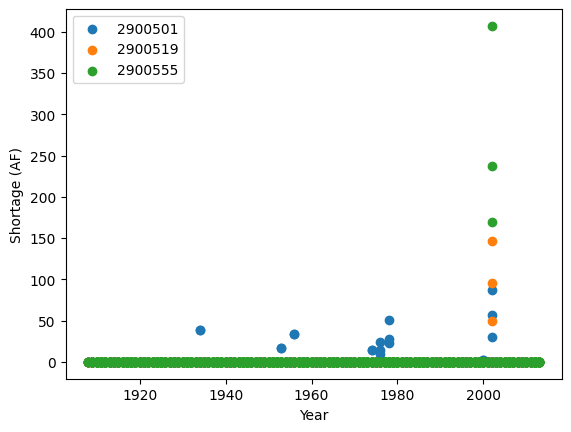

In [8]:
fig, ax = plt.subplots()

for name, group in data.groupby('structure_id'):
    ax.scatter(
        group['year'], group['shortage_total'], label=name)

plt.xlabel("Year")
plt.ylabel("Shortage (AF)")
plt.legend()

You can look up the names and rights of the users listed above in the `sj2015.ddr` file (found at `data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/sj2015.ddr`). Here, a higher Admin # denotes lower seniority. You'll see that the users chosen here have junior to medium seniority of water rights with varying amounts of water decreed to them. The figure above shows that all users have experienced shortages. User 2900501 has experienced the most frequent shortages respectively, likely due in part to their less senior water right. Generally, we see a higher magnitude of shortages for all users during the 2002 drought.  

### Step 2a: Modify StateMod Input Files for Exploratory Analyses- Demand Function Example

Now that we've run StateMod in baseline mode, the next step shows how we can run it in an exploratory analysis mode. To do this, we need to create some plausible futures and adjust the input files of StateMod to reflect these changes. In this step, we'll demonstrate Option 1 for statemodify adjustments using the [`.ddm`](https://opencdss.state.co.us/statemod/latest/doc-user/InputDescription/417/) file as an example, which involves multiplying the current demand time series for these users by a value in between 0.5 to 1.5. Here we specify the IDs of the users and the bounds from which we want to sample multipliers for the demand. We create 2 alternative states of the world (SOW) using a Latin hypercube sampling (LHS) procedure and store them in the `input_files` directory. 

In [11]:
# a dictionary to describe what users you want to modify and the bounds for the LHS
setup_dict = {
    "ids": ["2900501", "2900519","2900555"],
    "bounds": [0.5, 1.5]
}

output_directory = output_dir = os.path.join(data_dir, "input_files")

scenario = "1"

# the number of samples you wish to generate
n_samples = 2

# seed value for reproducibility if so desired
seed_value = 1

# number of rows to skip in file after comment
skip_rows = 1

# name of field to query
query_field = "id"

# number of jobs to launch in parallel; -1 is all but 1 processor used
n_jobs = -1

# basin to process
basin_name = "San_Juan"

# generate a batch of files using generated LHS
stm.modify_ddm(
    modify_dict=setup_dict,
    query_field=query_field,
    output_dir=output_directory,
    scenario=scenario,
    basin_name=basin_name,
    sampling_method="LHS",
    n_samples=n_samples,
    skip_rows=skip_rows,
    n_jobs=n_jobs,
    seed_value=seed_value,
    template_file=None,
    factor_method="multiply",
    data_specification_file=None,
    min_bound_value=-0.5,
    max_bound_value=1.5,
    save_sample=True
)


It's helpful to set `save_sample=True` to see the values of the multipliers that we are creating. We see below that in our 1st SOW, we are reducing demand for our users by 30% and then in our 2nd SOW, we are increasing demand for our users by 36%. 

In [12]:
sample_array = np.load(output_directory+'/ddm_2-samples_scenario-1.npy')
sample_array

array([[0.708511  ],
       [1.36016225]])

### Step 2b: Read in the New Input Files and Run StateMod : Demand Function Example

Now that we have created the input files, the next step is to run StateMod with the new input files. The file that StateMod uses to configure a simulation is called a [`.rsp`](https://opencdss.state.co.us/statemod/latest/doc-user/InputDescription/41/) file. For this dataset, the configuration file is `sj2015B.rsp`. This file contains the paths of all of the supporting files that StateMod needs to run. We create a template .rsp file (`sj2015B_template_ddm.rsp`) and swap in the path to the two new alternative `.ddm` files that are created. Then we run StateMod for the two scenarios and store the shortages in Parquet file format. Each scenario will take approximately 4 minutes.

In [9]:
# set realization and sample
realization = 1
sample = np.arange(0, 2, 1)

# read RSP template
with open(ddm_template_file) as template_obj:
    
    # read in file
    template_rsp = Template(template_obj.read())

    for i in sample:
        
        # create scenario name
        scenario = f"S{i}_{realization}"
        
        # dictionary holding search keys and replacement values to update the template file
        d = {"DDM": f"../../input_files/sj2015B_{scenario}.ddm"}
        
        # update the template
        new_rsp = template_rsp.safe_substitute(d)
        
        # construct simulated scenario directory
        simulated_scenario_dir = os.path.join(scenarios_dir_ddm, scenario)
        if not os.path.exists(simulated_scenario_dir):
            os.makedirs(simulated_scenario_dir)
            
        # target rsp file
        rsp_file = os.path.join(simulated_scenario_dir, f"sj2015B_{scenario}.rsp")
        
        # write updated rsp file
        with open(rsp_file, "w") as f1:
            f1.write(new_rsp)
        
        # construct simulated basin path
        simulated_basin_path = os.path.join(simulated_scenario_dir, f"sj2015B_{scenario}")

        # run StateMod
        print(f"Running: {scenario}")
        os.chdir(simulated_scenario_dir)

        subprocess.call([statemod_exe, simulated_basin_path, "-simulate"])
        
        #Save output to parquet files 
        print('creating parquet for ' + scenario)
        
        output_directory = os.path.join(parquet_dir_ddm+"/scenario/"+ scenario)
        
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        
        stm.xdd.convert_xdd(
            output_path=output_directory,
            allow_overwrite=False,
            xdd_files=scenarios_dir_ddm + "/"+ scenario + "/sj2015B_"+scenario+".xdd",
            id_subset=['2900501','2900519','2900555'],
            parallel_jobs=4,
            preserve_string_dtype=False
        )


Running: S0_1
 Startup log file for messages to this point: /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/scenarios_ddm/S0_1/sj2015B_S0_1.rsp                                                                                                                                                
   Closing startup log file: statem.log
   Opening dataset log file: /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/scenarios_ddm/S0_1/sj2015B_S0_1.log                                                                                                                                                
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version:     17.0.3          
        Last revision date: 2021/09/12

________________________________________________________________________
  
  Subroutine Execut
  Subro

OSError: parquet files already exist in /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/parquet_ddm/scenario/S0_1 but allow_overwrite is False

### Step 2c: Visualize Shortages in New SOWs- Demand Function Example

Now that we have run our simulations, we can visualize the difference in shortages experienced by the stakeholders in our two SOWs. Let's focus on the user: 2900501, a junior user who experienced the most frequent shortages historically across the stakeholders we looked at. Let's look back at the LHS sample and see that SOW 1 is where we have a decreased demand (0.7 multiplier) and SOW 2 is where we have an increased demand (1.4 multiplier).

In [10]:
output_directory = os.path.join(data_dir, "input_files")
sample_array = np.load(output_directory+'/ddm_2-samples_scenario-1.npy')
sample_array

array([[0.708511  ],
       [1.36016225]])

Now we can define shortages in the alternative states of the world with respect to the shortages received in the baseline case.

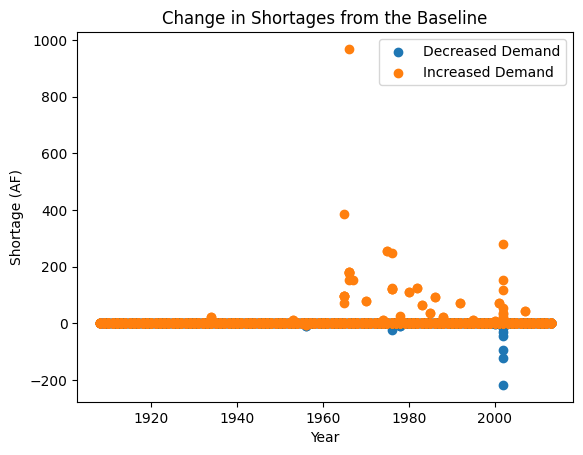

In [11]:
# Read in raw parquet files
baseline=pd.read_parquet(data_dir+'/historic_shortages/sj2015B.parquet',engine='pyarrow')
SOW_1=pd.read_parquet(parquet_dir_ddm+'/scenario/S0_1/sj2015B_S0_1.parquet',engine='pyarrow')
SOW_2=pd.read_parquet(parquet_dir_ddm+'/scenario/S1_1/sj2015B_S1_1.parquet',engine='pyarrow')

# Subtract shortages with respect to the baseline
subset_df=pd.concat([baseline['year'],baseline['shortage_total'],SOW_1['shortage_total'],SOW_2['shortage_total']],axis=1)
subset_df = subset_df.set_axis(['Year', 'Baseline', 'SOW_1','SOW_2'], axis=1)
subset_df['SOW_1_diff'] = subset_df['SOW_1']-subset_df['Baseline']
subset_df['SOW_2_diff'] = subset_df['SOW_2']-subset_df['Baseline']

# Plot shortages
fig, ax = plt.subplots()

ax.scatter(subset_df['Year'], subset_df['SOW_1_diff'],label='Decreased Demand')
ax.scatter(subset_df['Year'], subset_df['SOW_2_diff'],label='Increased Demand')

plt.xlabel("Year")
plt.ylabel("Shortage (AF)")
plt.title("Change in Shortages from the Baseline")
plt.legend()

As expected, we see that an increase in demand typically causes an increase in shortage magnitude and frequency whereas the reduction in demand leads to the opposite. This finishes our simple example to demonstrate how adjustments to demand might change the shortages experienced by a user. 

### Step 3a: Modify StateMod Input Files for Exploratory Analyses- Water Rights Function Example

Following from Step 2, we can run the same analysis for the function that manipulates the `sj2015.ddr` file, which corresponds to users water rights. In this function, we can specify the IDs of the users and can can utilize a variety of options for how we want to change the [`.ddr`](https://opencdss.state.co.us/statemod/latest/doc-user/InputDescription/46/) file. We can either sample from some bounds that apply multipliers to the decree, hard code in values for the decree, or adjust the rank of the user. In this simple example, we take a very junior user, ID: 2900501, and make them have the highest water right by changing their rank to 1. 

In [12]:
# a dictionary to describe what you want to modify and the bounds for the LHS
setup_dict = {
    # ids can either be 'struct' or 'id' values
    "ids": ["2900501"],

    # turn id on or off completely or for a given period
    # if 0 = off, 1 = on, YYYY = on for years >= YYYY, -YYYY = off for years > YYYY; see file header
    "on_off": [1],

    # apply rank of administrative order where 0 is lowest (senior) and n is highest (junior); None is no change
    "admin": [1],
}

output_directory = os.path.join(data_dir, "input_files")
scenario = "1"

# the number of samples you wish to generate
n_samples = 1

# seed value for reproducibility if so desired
seed_value = 1

# number of rows to skip in file after comment
skip_rows = 0

# name of field to query
query_field = "struct"

# number of jobs to launch in parallel; -1 is all but 1 processor used
n_jobs = -1

# basin to process
basin_name = "San_Juan"

# generate a batch of files using generated LHS
stm.modify_ddr(
    modify_dict=setup_dict,
    query_field=query_field,
    output_dir=output_directory,
    scenario=scenario,
    basin_name=basin_name,
    sampling_method="LHS",
    n_samples=n_samples,
    skip_rows=skip_rows,
    n_jobs=n_jobs,
    seed_value=seed_value,
    template_file=None,
    factor_method="multiply",
    data_specification_file=None,
    min_bound_value=-0.5,
    max_bound_value=1.5,
    save_sample=True
)


In the `input_files` directory, you can open the `sj2015B_S0_1.ddr` file and see that the Admin # of our selected user has now become 1.0000. Now we rerun our code to do the StateMod simulation, this time using the .`ddr` template file. 

In [13]:
# set realization and sample
realization = 1
sample = np.arange(0, 1, 1)

# read RSP template
with open(ddr_template_file) as template_obj:
    
    # read in file
    template_rsp = Template(template_obj.read())

    for i in sample:
        
        # create scenario name
        scenario = f"S{i}_{realization}"
        
        # dictionary holding search keys and replacement values to update the template file
        d = {"DDR": f"../../input_files/sj2015B_{scenario}.ddr"}
        
        # update the template
        new_rsp = template_rsp.safe_substitute(d)
        
        # construct simulated scenario directory
        simulated_scenario_dir = os.path.join(scenarios_dir_ddr, scenario)
        if not os.path.exists(simulated_scenario_dir):
            os.makedirs(simulated_scenario_dir)
            
        # target rsp file
        rsp_file = os.path.join(simulated_scenario_dir, f"sj2015B_{scenario}.rsp")
        
        # write updated rsp file
        with open(rsp_file, "w") as f1:
            f1.write(new_rsp)
        
        # construct simulated basin path
        simulated_basin_path = os.path.join(simulated_scenario_dir, f"sj2015B_{scenario}")

        # run StateMod
        print(f"Running: {scenario}")
        os.chdir(simulated_scenario_dir)

        subprocess.call([statemod_exe, simulated_basin_path, "-simulate"])
        
        #Save output to parquet files 
        print('creating parquet for ' + scenario)
        
        output_directory = os.path.join(parquet_dir_ddr+"/scenario/"+ scenario)
        
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        
        stm.xdd.convert_xdd(
            output_path=output_directory,
            allow_overwrite=False,
            xdd_files=scenarios_dir_ddr + "/"+ scenario + "/sj2015B_"+scenario+".xdd",
            id_subset=['2900501'],
            parallel_jobs=2,
            preserve_string_dtype=False
        )


Running: S0_1
 Startup log file for messages to this point: /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/scenarios_ddr/S0_1/sj2015B_S0_1.rsp                                                                                                                                                
   Closing startup log file: statem.log
   Opening dataset log file: /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/scenarios_ddr/S0_1/sj2015B_S0_1.log                                                                                                                                                
________________________________________________________________________

        StateMod                       
        State of Colorado - Water Supply Planning Model     

        Version:     17.0.3          
        Last revision date: 2021/09/12

________________________________________________________________________
  
  Subroutine Execut
  Subro

OSError: parquet files already exist in /home/jovyan/data/sj2015_StateMod_modified/sj2015_StateMod_modified/StateMod/parquet_ddr/scenario/S0_1 but allow_overwrite is False

As before, let's go ahead and plot the shortages for our User 2900501 with respect to the baseline shortages.

Text(0.5, 1.0, 'Change in Shortages from the Baseline')

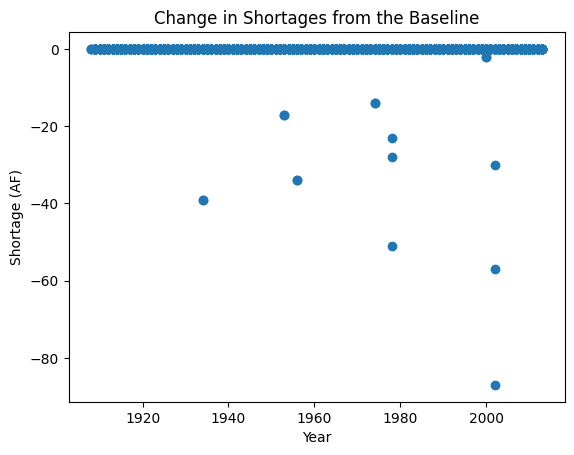

In [14]:
# Read in raw parquet files
baseline=pd.read_parquet(data_dir+'/historic_shortages/sj2015B.parquet',engine='pyarrow')
SOW_1=pd.read_parquet(parquet_dir_ddr+ '/scenario/S0_1/sj2015B_S0_1.parquet',engine='pyarrow')

# Subtract shortages with respect to the baseline
subset_df=pd.concat([baseline['year'],baseline['shortage_total'],SOW_1['shortage_total']],axis=1)
subset_df = subset_df.set_axis(['Year', 'Baseline', 'SOW_1'], axis=1)
subset_df['diff']=subset_df['SOW_1']-subset_df['Baseline']

# Plot shortages
fig, ax = plt.subplots()

ax.scatter(subset_df['Year'], subset_df['diff'])

plt.xlabel("Year")
plt.ylabel("Shortage (AF)")
plt.title("Change in Shortages from the Baseline")

We generally see the behavior we expect to see which is that with more senior water rights, the user sees a decrease in shortage magnitude. 

Now, continue on to Quickstarter Notebook #2 to learn how to use the reservoir evaporation modification fuction.

<div class="alert alert-block alert-warning"> 
    
<b>Tip:</b> If you are interested in understanding how to apply `statemodify` functions to your own model, take a look at the source code found in the repository here:   
    
    
<div>
    1.  <a href="https://github.com/IMMM-SFA/statemodify/blob/main/statemodify/ddm.py">modify_ddm()</a>

</div> 

<div>
    2.  <a href="https://github.com/IMMM-SFA/statemodify/blob/main/statemodify/ddr.py">modify_ddr()</a>

</div> 
  

</div>
